In [45]:
from bertopic import BERTopic

# Original model
original_model = BERTopic.load("bertopic_model_trial_8")

# Reduced model
reduced_model = BERTopic.load("bertopic_model_trial_8_reduced")

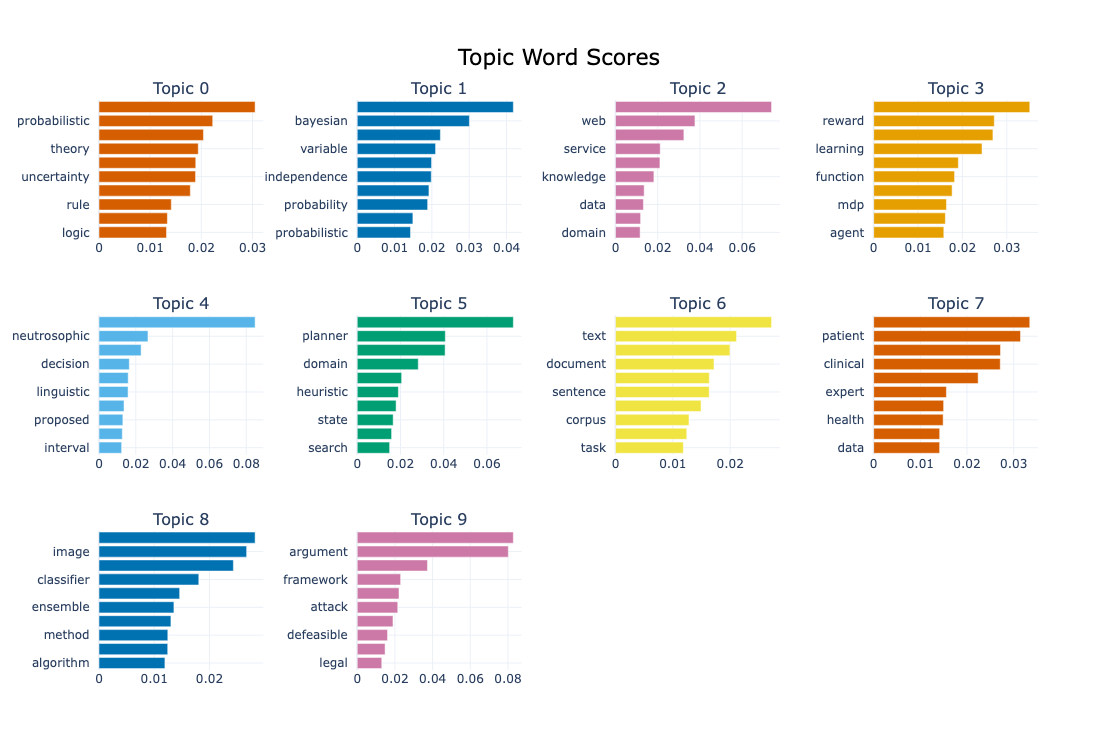

In [47]:
original_model.visualize_barchart(top_n_topics=10, n_words=10)

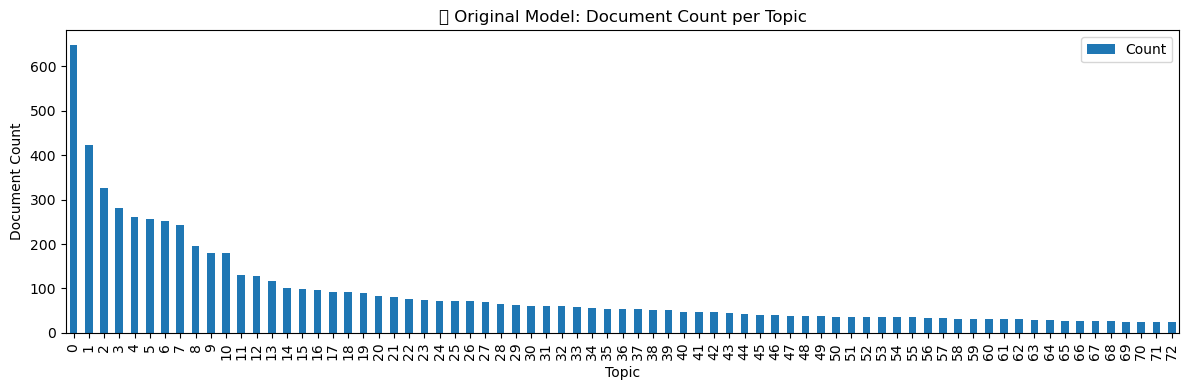

In [49]:
import matplotlib.pyplot as plt

original_info = original_model.get_topic_info()
topic_counts = original_info[original_info.Topic != -1][["Topic", "Count"]].set_index("Topic").sort_index()

topic_counts.plot(kind="bar", figsize=(12, 4))
plt.title("📄 Original Model: Document Count per Topic")
plt.ylabel("Document Count")
plt.xlabel("Topic")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

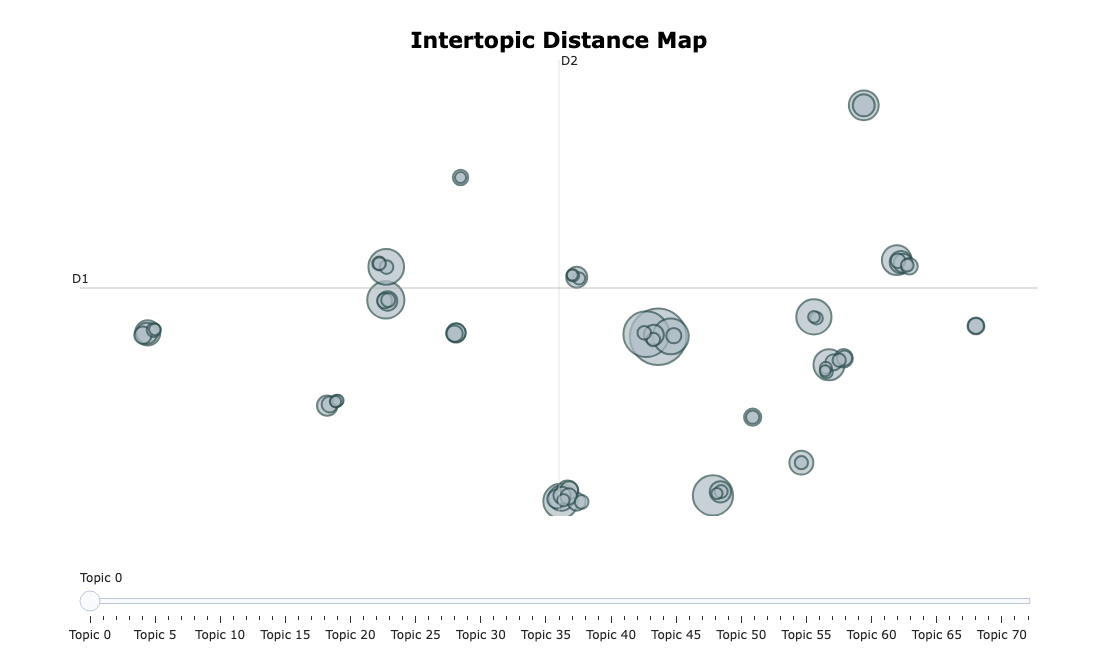

In [51]:
original_model.visualize_topics()

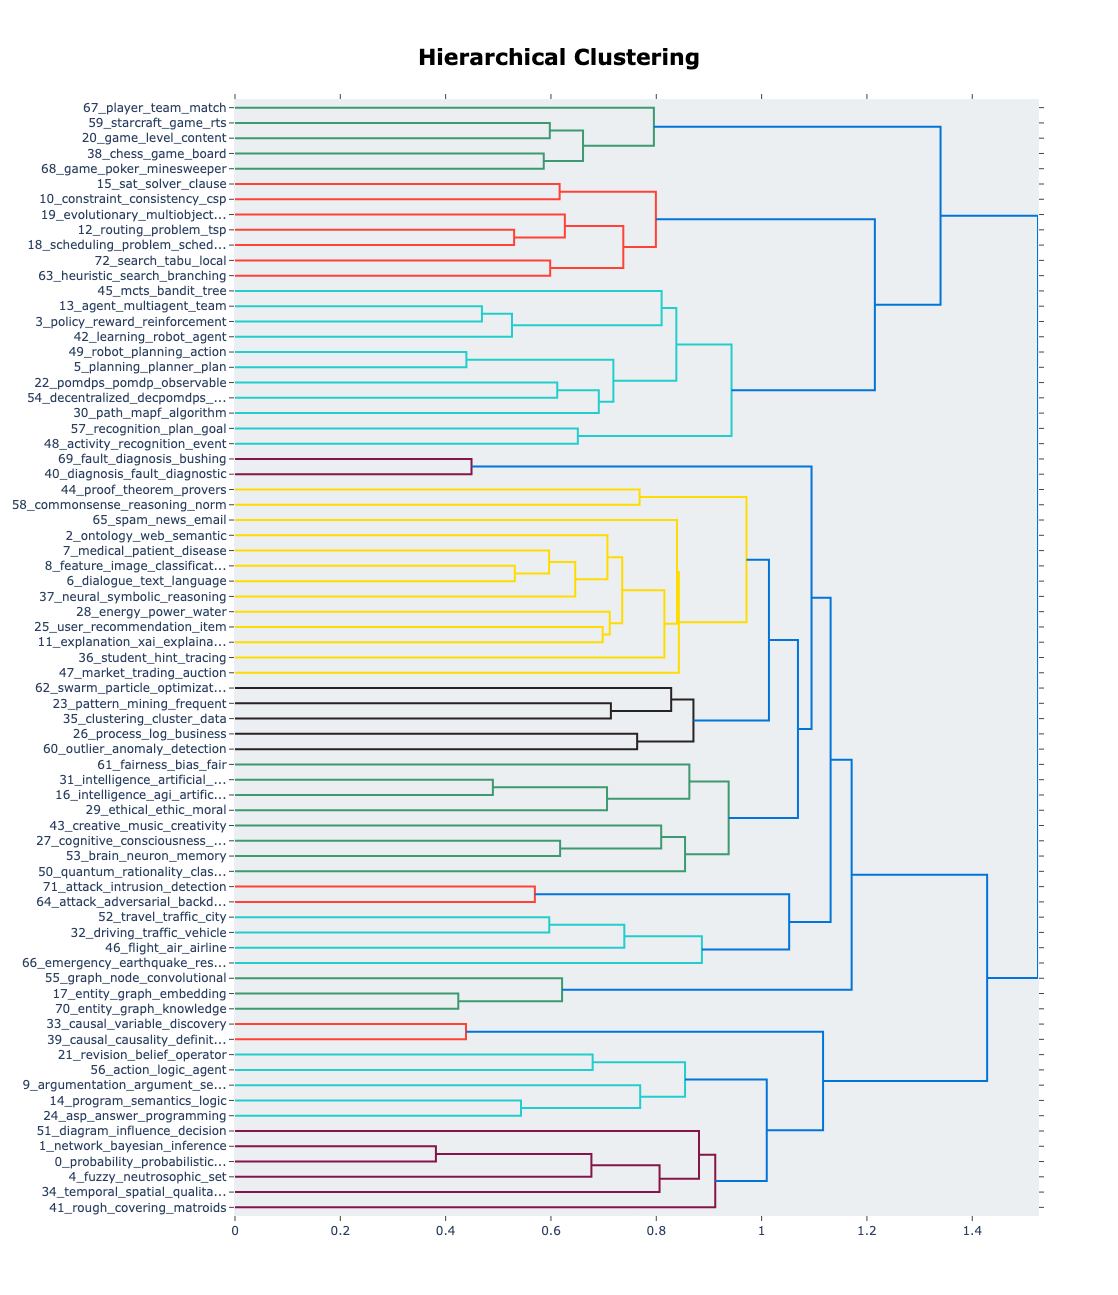

In [53]:
original_model.visualize_hierarchy()

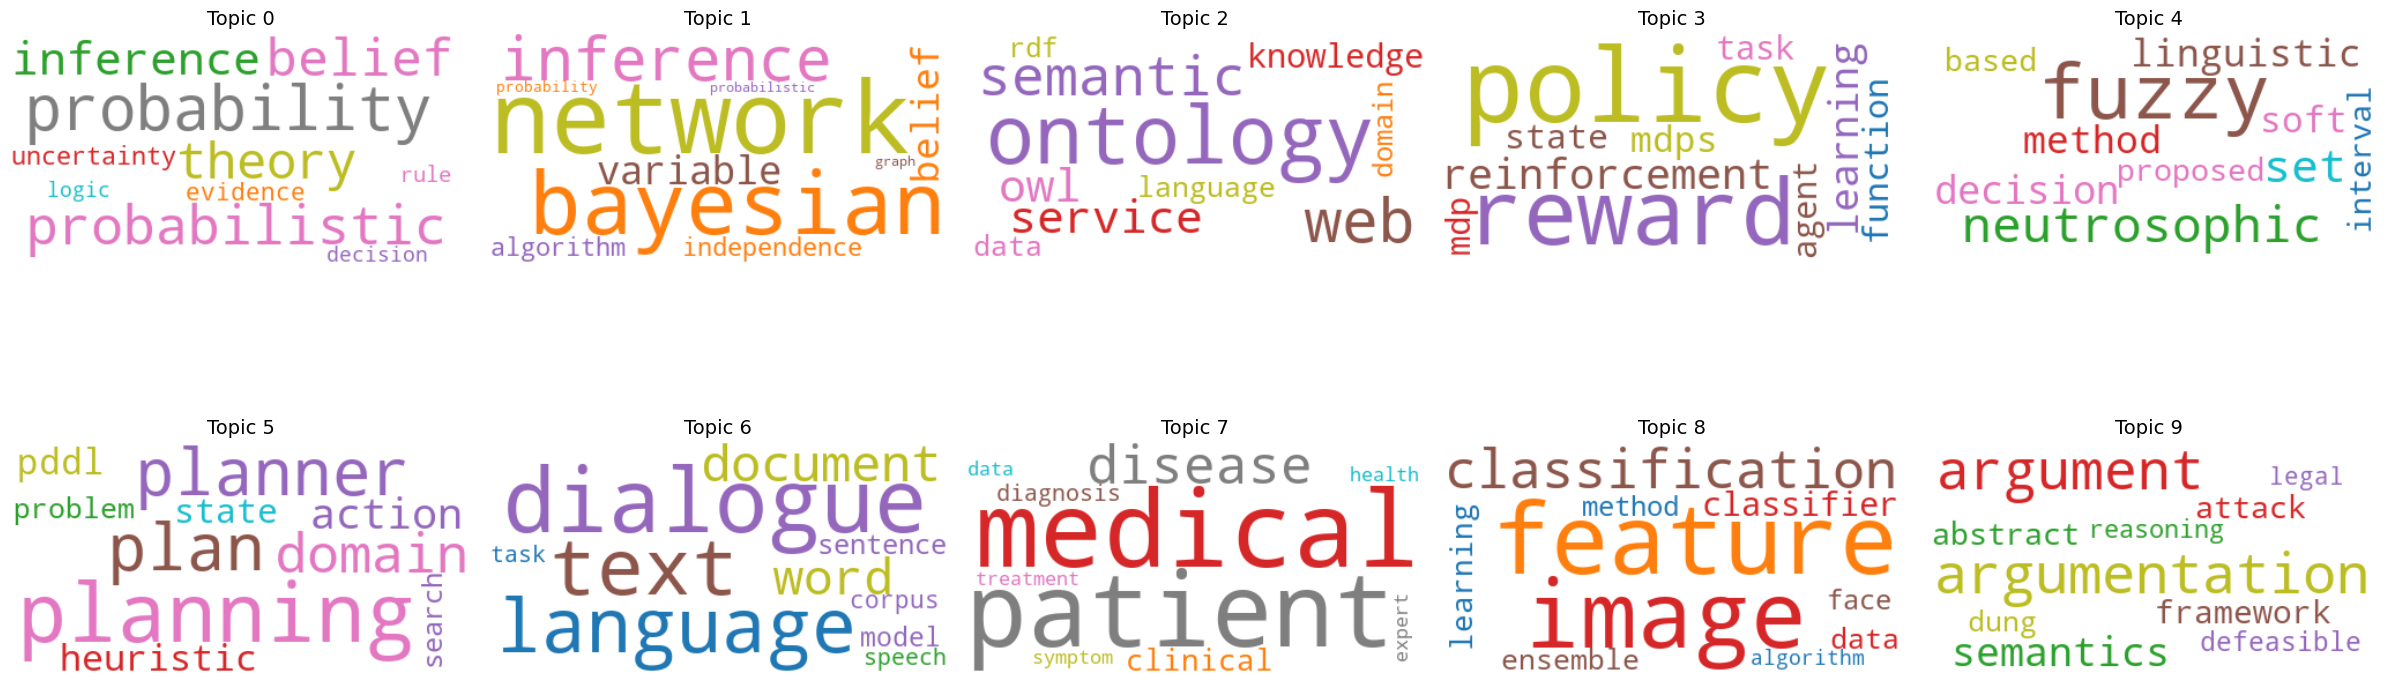

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get top 10 topics (excluding noise)
topic_info = original_model.get_topic_info()
top_topics = topic_info[topic_info.Topic != -1].nlargest(10, 'Count')["Topic"].tolist()

# Set up subplot grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
axes = axes.flatten()  # make indexing easier

# Loop through each topic and generate its word cloud
for i, topic_num in enumerate(top_topics):
    words_scores = original_model.get_topic(topic_num)
    word_freq = {word: score for word, score in words_scores}

    # Generate word cloud
    wordcloud = WordCloud(
        background_color='white',
        width=400,
        height=200,
        colormap='tab10'
    ).generate_from_frequencies(word_freq)

    # Plot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(f"Topic {topic_num}", fontsize=14)

# Hide any unused axes (if < 10 topics)
for j in range(len(top_topics), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

**Reduced model**

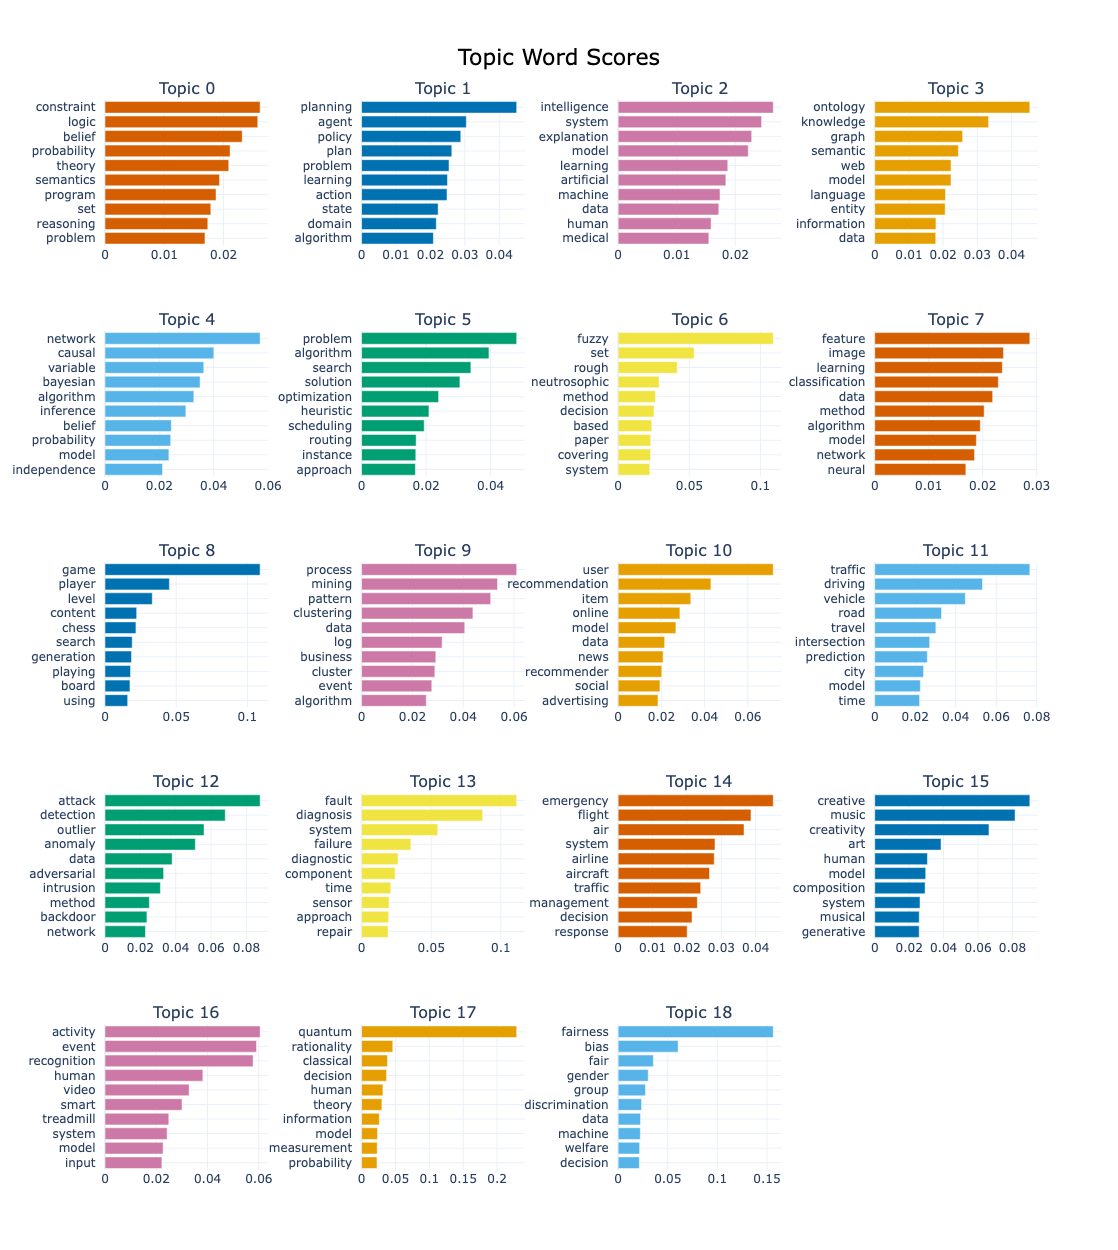

In [92]:
reduced_model.visualize_barchart(top_n_topics=20, n_words=10)

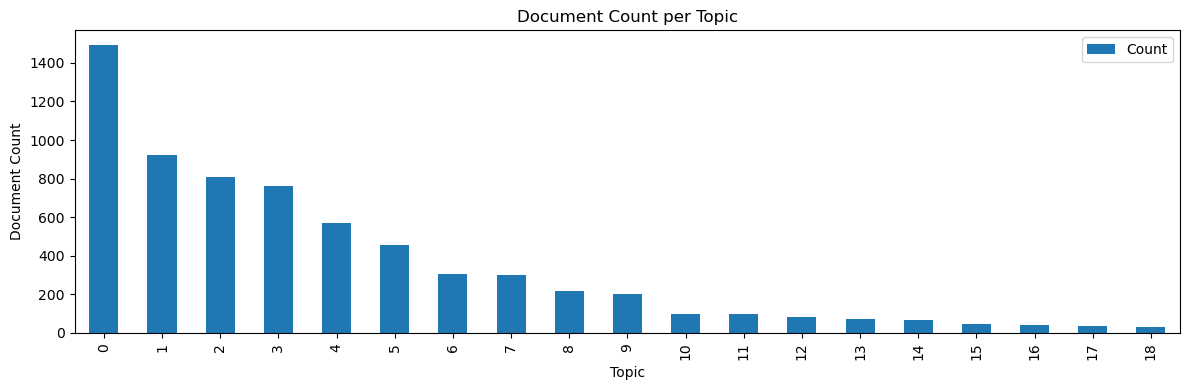

In [90]:
import matplotlib.pyplot as plt

topic_info = reduced_model.get_topic_info()
topic_counts = topic_info[topic_info.Topic != -1][["Topic", "Count"]].set_index("Topic").sort_index()

topic_counts.plot(kind="bar", figsize=(12, 4))
plt.title("Document Count per Topic")
plt.ylabel("Document Count")
plt.xlabel("Topic")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

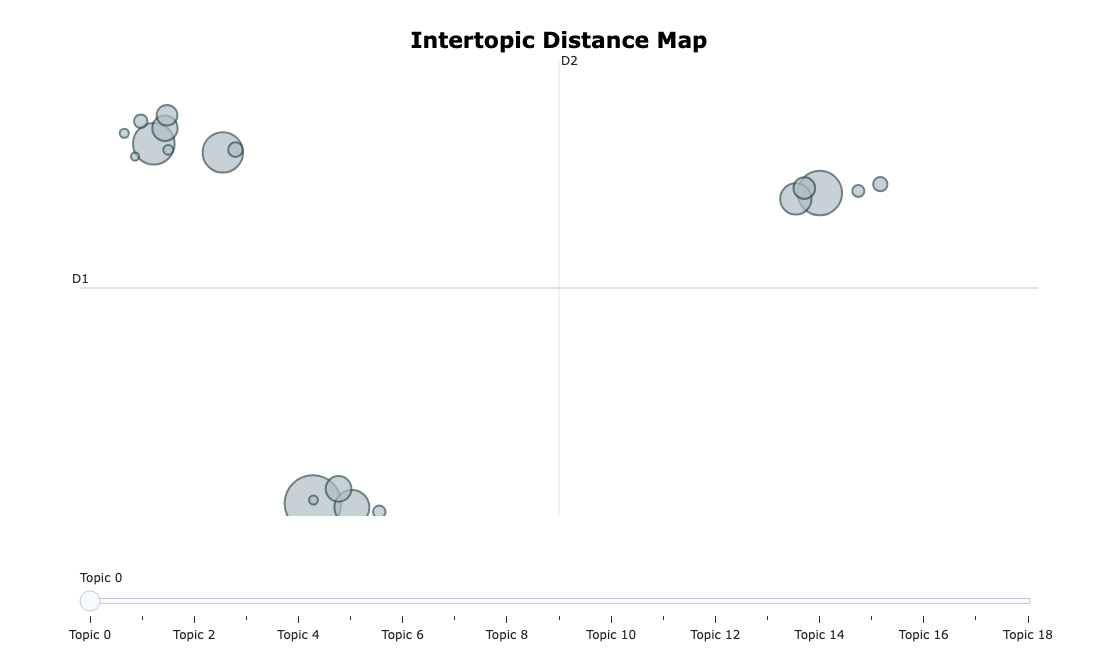

In [62]:
reduced_model.visualize_topics()

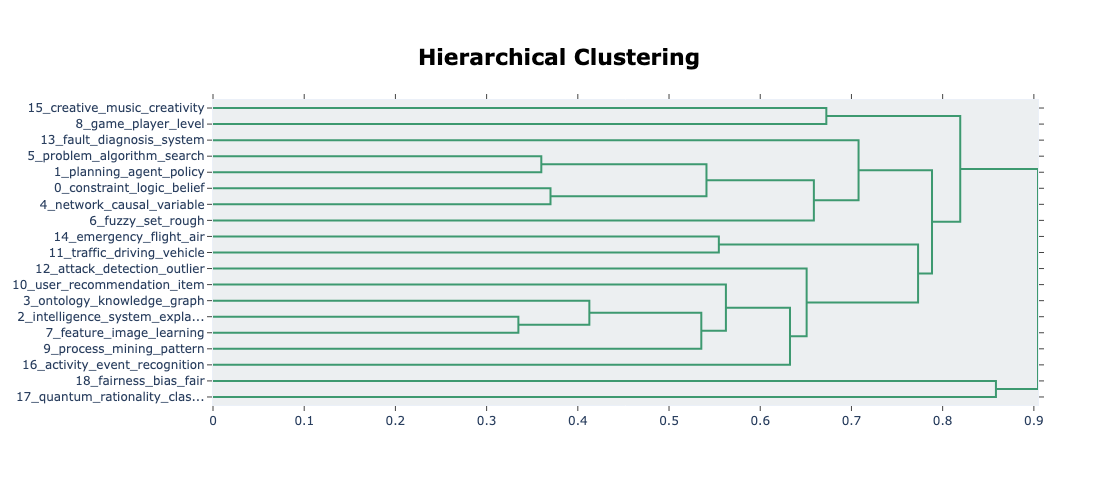

In [64]:
reduced_model.visualize_hierarchy()

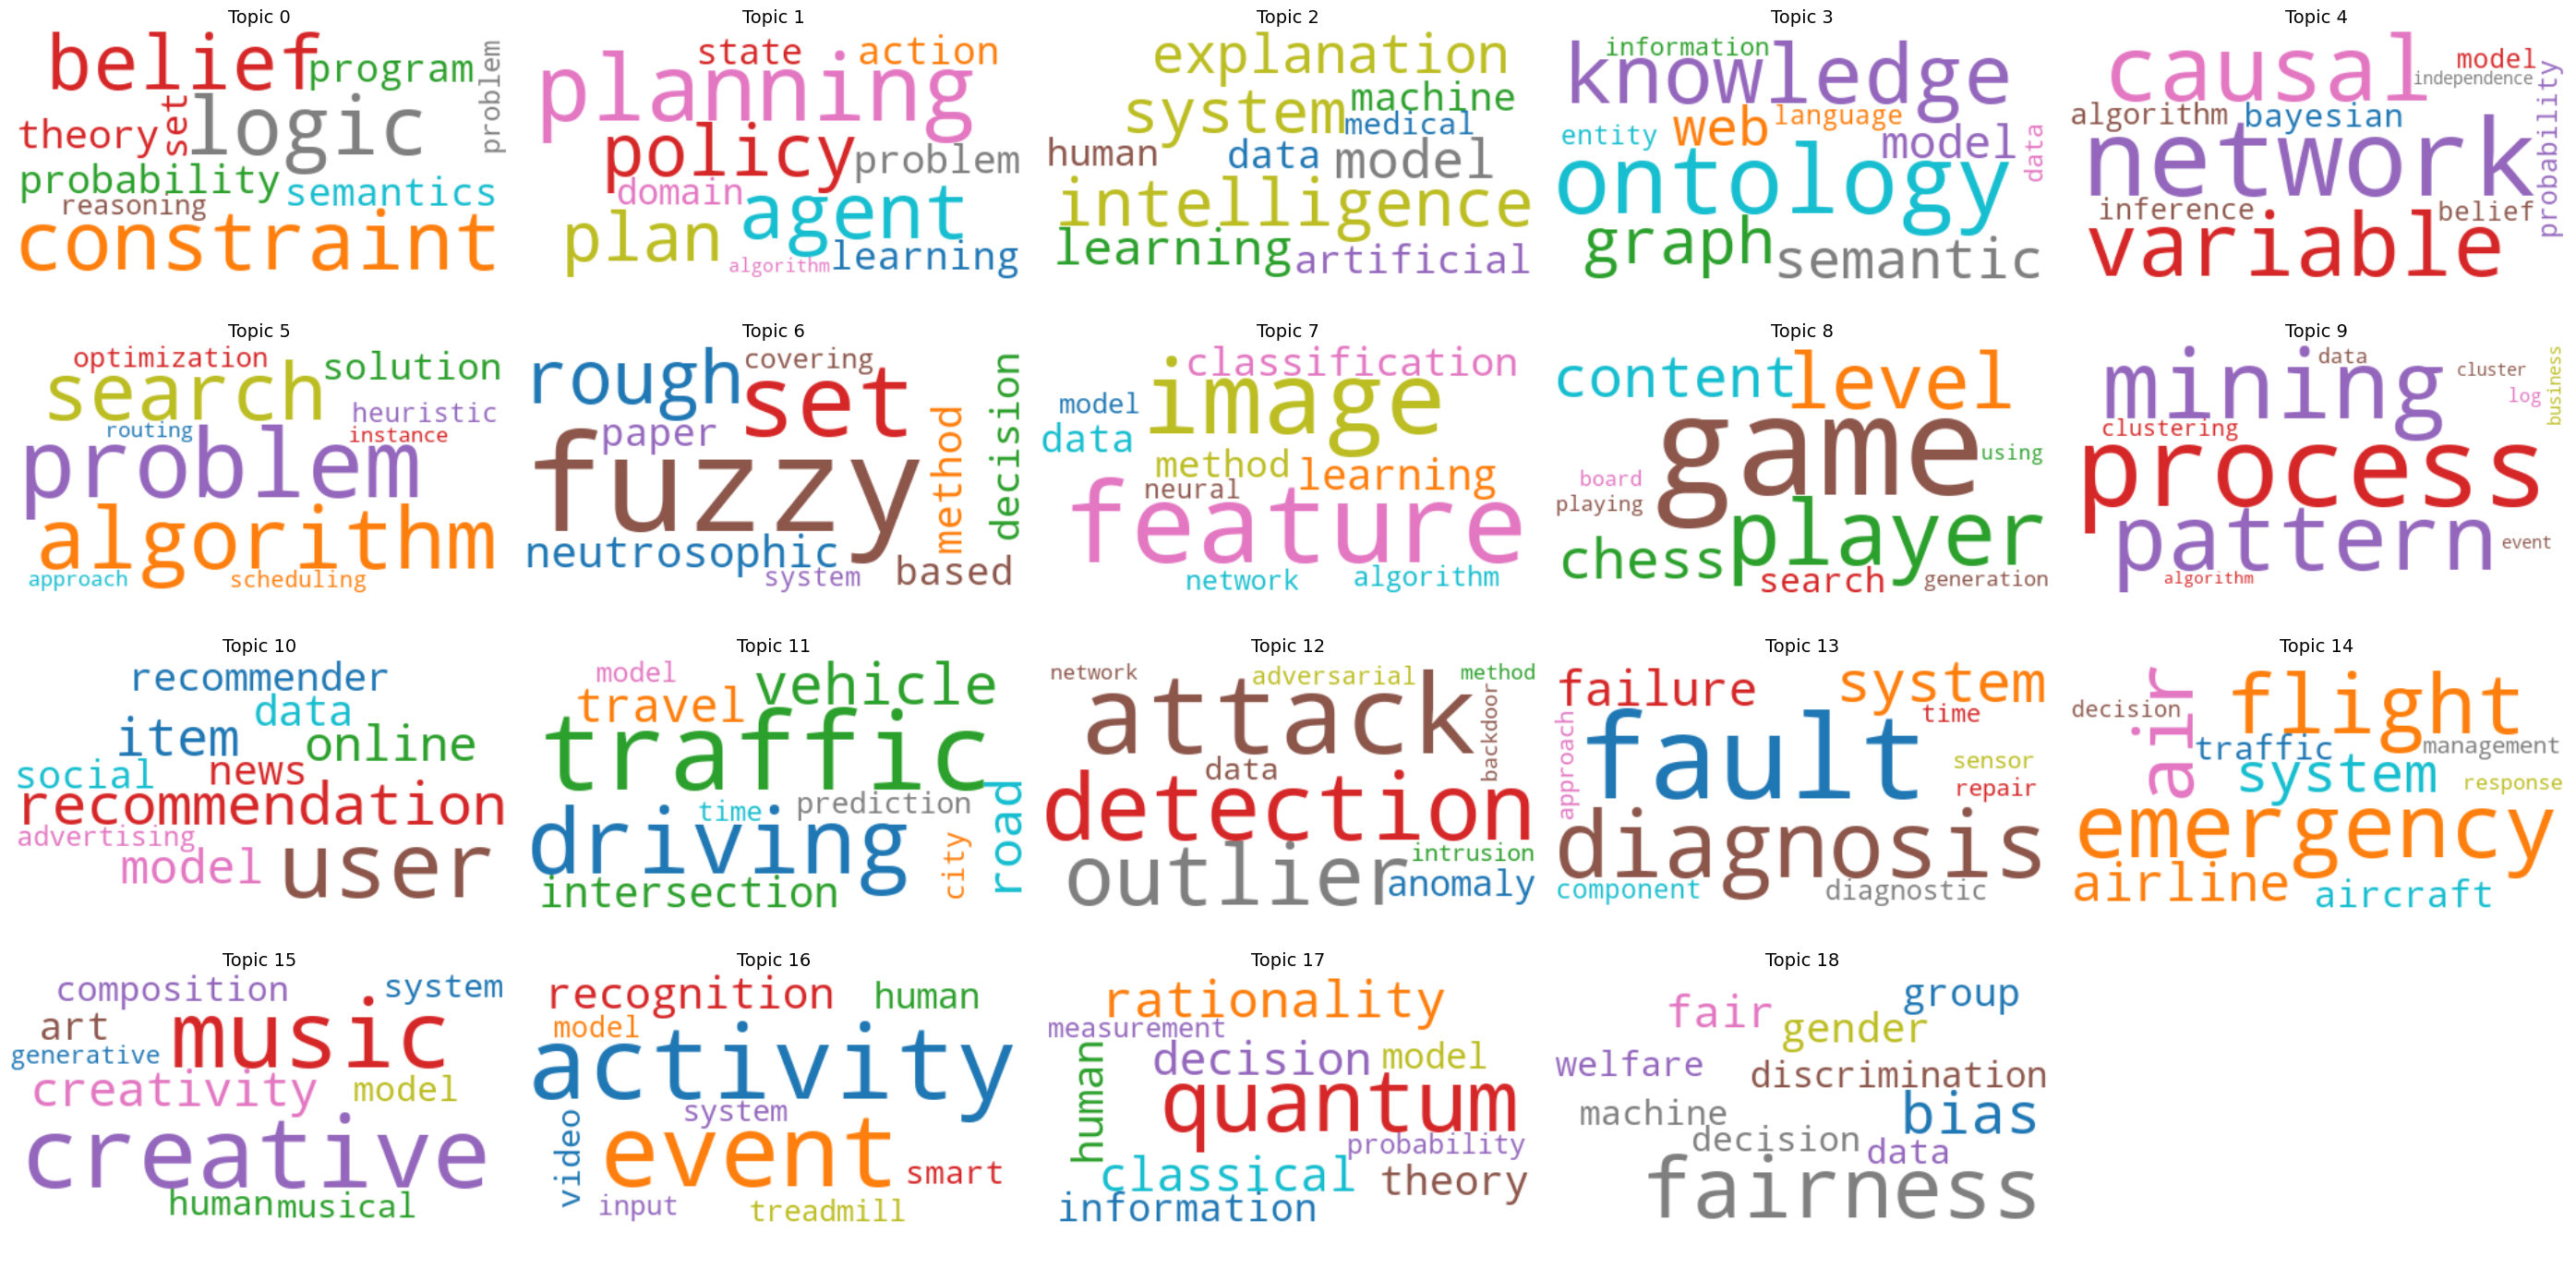

In [98]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get top 10 topics (excluding noise)
topic_info = reduced_model.get_topic_info()
top_topics = topic_info[topic_info.Topic != -1].nlargest(20, 'Count')["Topic"].tolist()

# Set up subplot grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(28, 14))
axes = axes.flatten()  # make indexing easier

# Loop through each topic and generate its word cloud
for i, topic_num in enumerate(top_topics):
    words_scores = reduced_model.get_topic(topic_num)
    word_freq = {word: score for word, score in words_scores}

    # Generate word cloud
    wordcloud = WordCloud(
        background_color='white',
        width=400,
        height=200,
        colormap='tab10'
    ).generate_from_frequencies(word_freq)

    # Plot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(f"Topic {topic_num}", fontsize=14)

# Hide any unused axes (if < 10 topics)
for j in range(len(top_topics), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

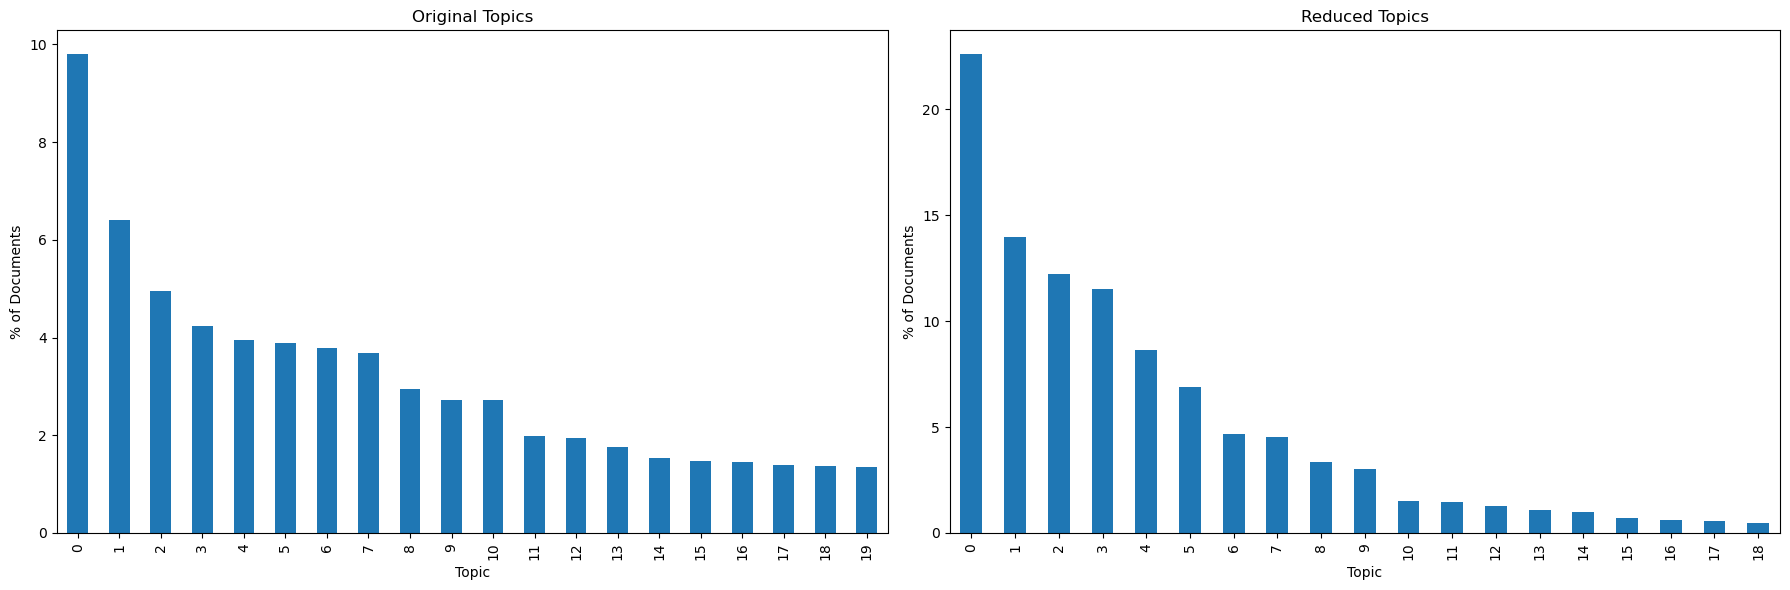

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Get topic counts (excluding -1)
original_counts = original_model.get_topic_info()
reduced_counts = reduced_model.get_topic_info()

original_counts = original_counts[original_counts.Topic != -1][["Topic", "Count"]].set_index("Topic")
reduced_counts = reduced_counts[reduced_counts.Topic != -1][["Topic", "Count"]].set_index("Topic")

# Normalize to percentage for fair comparison
original_counts["Percent"] = original_counts["Count"] / original_counts["Count"].sum() * 100
reduced_counts["Percent"] = reduced_counts["Count"] / reduced_counts["Count"].sum() * 100

# Sort by size and take top N
N = 20
top_original = original_counts.sort_values("Percent", ascending=False).head(N)
top_reduced = reduced_counts.sort_values("Percent", ascending=False).head(N)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

top_original["Percent"].plot(kind="bar", ax=axes[0], title="Original Topics")
axes[0].set_ylabel("% of Documents")
axes[0].set_xlabel("Topic")

top_reduced["Percent"].plot(kind="bar", ax=axes[1], title="Reduced Topics")
axes[1].set_ylabel("% of Documents")
axes[1].set_xlabel("Topic")

plt.tight_layout()
plt.show()

In [72]:
df = pd.read_csv("/Users/moo/Desktop/MSc Business Analytics/BEMM466 Business project/BERTopic Finalised/arxiv_ai_cleaned_ready.csv")

In [88]:
import pandas as pd
import numpy as np
from bertopic import BERTopic

# === Load data and precomputed embeddings ===
df = pd.read_csv("/Users/moo/Desktop/MSc Business Analytics/BEMM466 Business project/BERTopic Finalised/arxiv_ai_cleaned_ready.csv")
docs = df["summary_clean"].tolist()

embeddings = np.load("embeddings.npy")
assert len(docs) == len(embeddings), "⚠️ Mismatch between documents and embeddings!"

# Make a working copy
df_export = df.copy()

# === Load ORIGINAL model and transform with embeddings ===
original_model = BERTopic.load("bertopic_model_trial_8")
original_topics, original_probs = original_model.transform(docs, embeddings=embeddings)

df_export['original_topic'] = original_topics
df_export['original_topic_prob'] = np.max(original_probs, axis=1)

# Generate readable labels for original topics
original_info = original_model.get_topic_info()
original_label_map = {
    row["Topic"]: row["Name"].split("_", 1)[-1] for _, row in original_info.iterrows()
}
original_label_map[-1] = "Noise / Outlier"
df_export['original_topic_label'] = df_export['original_topic'].map(original_label_map)

# === Load REDUCED model and transform with same embeddings ===
reduced_model = BERTopic.load("bertopic_model_trial_8_reduced")
reduced_topics, reduced_probs = reduced_model.transform(docs, embeddings=embeddings)

df_export['reduced_topic'] = reduced_topics
df_export['reduced_topic_prob'] = np.max(reduced_probs, axis=1)

# Generate readable labels for reduced topics
reduced_info = reduced_model.get_topic_info()
reduced_label_map = {
    row["Topic"]: row["Name"].split("_", 1)[-1] for _, row in reduced_info.iterrows()
}
reduced_label_map[-1] = "Noise / Outlier"
df_export['reduced_topic_label'] = df_export['reduced_topic'].map(reduced_label_map)

# === Sort and Export ===
df_export = df_export.sort_values(by="reduced_topic")
df_export.to_csv("arxiv_ai_with_original_and_reduced_topics.csv", index=False)

print("Exported to: arxiv_ai_with_original_and_reduced_topics.csv")

Exported to: arxiv_ai_with_original_and_reduced_topics.csv
